## Deep Learning for Mortality Prediction (DLMP)

### Import packages 

In [51]:
import tensorflow as tf
import csv
import numpy as np
import pandas as pd
import os as os
import matplotlib.pyplot as plt
tfkl = tf.keras.layers

### Import functions

In [50]:
import dl_functions
import lc_functions
import figure_functions

### Import data

In [3]:
# loading in USMDB data
data = []
ages = []
states = []
genders = []

with open("../data/usmdb/usmdb.csv", "r") as file:
    reader = csv.reader(file,delimiter=',')
    for row_index, row in enumerate(reader):
        if row_index == 0:
            print(row)
        if row_index >= 1:
            state, gender, year, age, rate = row
            year = int(year)
            try:
                age = int(age)
            except:
                age = -1
            if state not in states:
                states.append(state)
            state = states.index(state)
            if gender not in genders:
                genders.append(gender)
            gender = genders.index(gender)
            try:
                rate = float(rate)
            except:
                rate = -1
            if rate > 1:
                rate = 1
            # get rid of years, ages, not in health data and other cleaning
            if age != -1 and rate != -1 and age <= 99:
                data.append([state, gender, year, age, rate])

state_data = np.array(data)

['PopName', 'Sex', 'Year', 'Age', 'mx']


In [5]:
# loading in HMD data
data = []
ages = []
countries = []
genders = []

with open("../data/hmd.csv", "r") as file:
    reader = csv.reader(file,delimiter=",")
    for row_index, row in enumerate(reader):
        if row_index == 0:
            print(row)
        if row_index >= 1:
            country, gender, year, age, rate = row
            year = int(year)
            try:
                age = int(age)
            except:
                age = -1
            if country not in countries:
                countries.append(country)
            country = countries.index(country)
            if gender not in genders:
                genders.append(gender)
            gender = genders.index(gender)
            try:
                rate = float(rate)
            except:
                rate = -1
            if rate > 1:
                rate = 1
            if age != -1 and rate != -1 and age <= 99:
                data.append([country, gender, year, age, rate])

country_data = np.array(data)

# getting unique values for geographic location column 
country_data[:,0] = country_data[:,0] + 50

['Country', 'Gender', 'Year', 'Age', 'Mortality_rate']


In [7]:
geos_list = states + countries
geos_index = np.arange(88)
geos_key = np.column_stack((np.array(geos_list), geos_index))

array([['AK', '0'],
       ['AL', '1'],
       ['AZ', '2'],
       ['AR', '3'],
       ['CA', '4'],
       ['CO', '5'],
       ['CT', '6'],
       ['DE', '7'],
       ['FL', '8'],
       ['GA', '9'],
       ['HI', '10'],
       ['ID', '11'],
       ['IL', '12'],
       ['IN', '13'],
       ['IA', '14'],
       ['KS', '15'],
       ['KY', '16'],
       ['LA', '17'],
       ['ME', '18'],
       ['MD', '19'],
       ['MA', '20'],
       ['MI', '21'],
       ['MN', '22'],
       ['MS', '23'],
       ['MO', '24'],
       ['MT', '25'],
       ['NE', '26'],
       ['NV', '27'],
       ['NH', '28'],
       ['NJ', '29'],
       ['NM', '30'],
       ['NY', '31'],
       ['NC', '32'],
       ['ND', '33'],
       ['OH', '34'],
       ['OK', '35'],
       ['OR', '36'],
       ['PA', '37'],
       ['RI', '38'],
       ['SC', '39'],
       ['SD', '40'],
       ['TN', '41'],
       ['TX', '42'],
       ['UT', '43'],
       ['VT', '44'],
       ['VA', '45'],
       ['WA', '46'],
       ['WV', '47'],
  

### Train Seperate DL Models for Country and State Data

#### State Model

In [12]:
# training set includes data from years 1959-2005
training_index = np.logical_and(state_data[:, 2] >= 1959, state_data[:, 2] <= 2005)
state_training = state_data[training_index, :]

# test set 1 includes years 2005-2015
test_index = np.logical_and(state_data[:, 2] > 2005, state_data[:, 2] <= 2015)
state_test = state_data[test_index, :]

# final test set that I'm not touching until the very end is 2015-2019
final_test_index = np.logical_and(state_data[:, 2] > 2015, state_data[:, 2] <= 2019)
state_final_test = state_data[final_test_index, :]

In [45]:
state_train_prepped = dl_functions.prep_data(state_training, mode="train")
state_test_prepped = dl_functions.prep_data(state_test, mode="test")
# state_test_prepped = prep_data(state_test, mode="not_random")
state_final_test_prepped = dl_functions.prep_data(state_final_test, mode="test")

In [14]:
# get the proper geography input dimension for model set up 
unique_vals = tf.unique(state_training[:, 0]).y
state_geo_dim = np.array(tf.size(unique_vals)).item()
print(state_geo_dim)

50


In [15]:
model_state, loss_info_state = dl_functions.run_deep_model(state_train_prepped, state_test_prepped, state_geo_dim, 1)

1000/1000 - 14s - 14ms/step - loss: 0.0135 - val_loss: 4.0740e-04 - learning_rate: 0.0010


#### Country Model

In [17]:
# training and test sets 
training_index = np.logical_and(country_data[:, 2] >= 1959, country_data[:, 2] <= 2005)
country_training = country_data[training_index, :]

test_index = np.logical_and(country_data[:, 2] > 2005, country_data[:, 2] <= 2015)
country_test = country_data[test_index, :]

final_test_index = np.logical_and(country_data[:, 2] > 2015, country_data[:, 2] <= 2019)
country_final_test = country_data[final_test_index, :]

In [18]:
country_train_prepped = dl_functions.prep_data(country_training, mode="train")
country_test_prepped = dl_functions.prep_data(country_test, mode="test")
# country_test_prepped = prep_data(country_test, mode="not_random")
country_final_test_prepped = dl_functions.prep_data(country_final_test, mode="test")

In [19]:
country_dim = int(np.max(country_data[:,0]) + 1)
country_dim

88

In [20]:
model_country, loss_info_country = dl_functions.run_deep_model(country_train_prepped, country_test_prepped, country_dim, 1)

1000/1000 - 12s - 12ms/step - loss: 0.0144 - val_loss: 4.7237e-04 - learning_rate: 0.0010


In [21]:
print(loss_info_country)

{'train_mse': 0.014444717206060886, 'val_mse': 0.0004723689053207636}


### Train Combined DL Model

In [22]:
# merge data
combined = np.vstack((state_data, country_data))

In [23]:
training_index = np.logical_and(combined[:, 2] >= 1959, combined[:, 2] <= 2005)
combined_training = combined[training_index, :]

test_index = np.logical_and(combined[:, 2] > 2005, combined[:, 2] <= 2015)
combined_test = combined[test_index, :]

final_test_index = np.logical_and(combined[:, 2] > 2015, combined[:, 2] <= 2019)
combined_final_test = combined[final_test_index, :]

In [24]:
combined_train_prepped = dl_functions.prep_data(combined_training, mode="train")
combined_test_prepped = dl_functions.prep_data(combined_test, mode="test")
combined_final_test_prepped = dl_functions.prep_data(combined_final_test, mode="test")

In [25]:
# get the proper geography input dimension for model set up 
unique_vals = tf.unique(combined_training[:, 0]).y
combined_geo_dim = np.array(tf.size(unique_vals)).item()
print(combined_geo_dim)

88


In [26]:
model_combined, loss_info_combined = dl_functions.run_deep_model(combined_train_prepped, combined_test_prepped, combined_geo_dim, 3)

Epoch 1/3
1000/1000 - 12s - 12ms/step - loss: 0.0141 - val_loss: 5.4210e-04 - learning_rate: 0.0010
Epoch 2/3
1000/1000 - 9s - 9ms/step - loss: 0.0012 - val_loss: 5.6909e-04 - learning_rate: 0.0010
Epoch 3/3
1000/1000 - 10s - 10ms/step - loss: 6.9309e-04 - val_loss: 3.0815e-04 - learning_rate: 0.0010


In [27]:
test = model_combined.evaluate(combined_test_prepped)

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 2.9726e-04


In [28]:
# print combined loss info (loss for states and countries using full dataset)
print(loss_info_combined)
print(test)

{'train_mse': 0.0006930886302143335, 'val_mse': 0.0003081544127780944}
0.00029644850292243063


### MSE for states only from combined model

In [29]:
mse = model_combined.evaluate(state_test_prepped)

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 8.7734e-05


### MSE for countries only from combined model

In [30]:
country_mse_combined = model_combined.evaluate(country_test_prepped)

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 5.9739e-04


### Train Lee-Carter model

In [31]:
# non-tensor train / test split (same years in training / test here as in method above)
training_index = np.logical_and(combined[:, 2] >= 1959, combined[:, 2] <= 2005)
training_data = combined[training_index, :]

test_index = np.logical_and(combined[:, 2] > 2005, combined[:, 2] <= 2015)
test_data = combined[test_index, :]

final_test_index = np.logical_and(combined[:, 2] > 2015, combined[:, 2] <= 2019)
final_test = combined[final_test_index, :]

In [37]:
lc_output, lc_predictions, lc_val_mse = lc_functions.run_lc_model(train_data=training_data, test_data=test_data)

Skipping Geo: 74.0, Gender: 1.0 due to NaN or infinite values in m_x


In [38]:
print(lc_predictions)

[[0.00000000e+00 0.00000000e+00 2.00600000e+03 0.00000000e+00
  1.18153311e-02]
 [0.00000000e+00 0.00000000e+00 2.00600000e+03 1.00000000e+00
  8.34357926e-04]
 [0.00000000e+00 0.00000000e+00 2.00600000e+03 2.00000000e+00
  3.61102455e-04]
 ...
 [8.70000000e+01 1.00000000e+00 2.01500000e+03 9.70000000e+01
  3.67681847e-01]
 [8.70000000e+01 1.00000000e+00 2.01500000e+03 9.80000000e+01
  3.84246870e-01]
 [8.70000000e+01 1.00000000e+00 2.01500000e+03 9.90000000e+01
  4.02592259e-01]]


### Generate Table 1: Training and Test MSEs
This table will document average MSEs (for states alone, countries alone, and total) over 5 training runs with each model (LC, deep learning seperate, deep learning joint)

In [39]:
def compare_models(num_iterations):
    results = []
    for i in range(num_iterations):
        lc = lc_functions.run_lc_model(train_data=training_data, test_data=test_data)
        print(f"Lee Carter Iteration {i} Complete")

        state_model, state_only = dl_functions.run_deep_model(dataset_train=state_train_prepped, dataset_test=state_test_prepped, geo_dim=state_geo_dim, epochs=30)
        country_model, country_only = dl_functions.run_deep_model(dataset_train=country_train_prepped, dataset_test=country_test_prepped, geo_dim=country_dim, epochs=30)

        ind_ave = ((state_only['val_mse']*50) + (country_only['val_mse']*37)) / 87
        seperate_dl = [state_only['val_mse'], country_only['val_mse'], ind_ave]
        print(f"Seperate DL Iteration {i} Complete")

        model_combined, loss_info_combined = dl_functions.run_deep_model(combined_train_prepped, combined_test_prepped, combined_geo_dim, epochs=30)

        state_combined = model_combined.evaluate(state_test_prepped)
        country_combined = model_combined.evaluate(country_test_prepped)
        total_combined = model_combined.evaluate(combined_test_prepped)

        combined_dl = [state_combined, country_combined, total_combined]
        print(f"Combined DL Iteration {i} Complete")

        results.append((lc, seperate_dl, combined_dl))

    return results
        

Comparison results are computationally costly to generate. Could be good to look into how Savio could help to speed this up. 

In [40]:
comparison_results = compare_models(num_iterations=1)

Skipping Geo: 74.0, Gender: 1.0 due to NaN or infinite values in m_x
Lee Carter Iteration 0 Complete
Epoch 1/30
1000/1000 - 15s - 15ms/step - loss: 0.0136 - val_loss: 3.5927e-04 - learning_rate: 0.0010
Epoch 2/30
1000/1000 - 10s - 10ms/step - loss: 6.8627e-04 - val_loss: 7.4610e-04 - learning_rate: 0.0010
Epoch 3/30
1000/1000 - 11s - 11ms/step - loss: 3.5936e-04 - val_loss: 2.3079e-04 - learning_rate: 0.0010
Epoch 4/30
1000/1000 - 10s - 10ms/step - loss: 2.4905e-04 - val_loss: 2.0803e-04 - learning_rate: 0.0010
Epoch 5/30
1000/1000 - 13s - 13ms/step - loss: 1.8110e-04 - val_loss: 6.3281e-05 - learning_rate: 0.0010
Epoch 6/30
1000/1000 - 11s - 11ms/step - loss: 1.4299e-04 - val_loss: 3.8860e-05 - learning_rate: 0.0010
Epoch 7/30
1000/1000 - 10s - 10ms/step - loss: 1.3614e-04 - val_loss: 4.9409e-05 - learning_rate: 0.0010
Epoch 8/30
1000/1000 - 10s - 10ms/step - loss: 1.1266e-04 - val_loss: 7.0709e-05 - learning_rate: 0.0010
Epoch 9/30
1000/1000 - 11s - 11ms/step - loss: 9.6178e-05 - val

In [42]:
lc_results = np.array([result[0][0] for result in comparison_results])
seperate_dl_results = np.array([result[1] for result in comparison_results])
combined_dl_results = np.array([result[2] for result in comparison_results])

In [47]:
lc_avg = np.mean(lc_results, axis=0)
seperate_dl_avg = np.mean(seperate_dl_results, axis=0)
combined_dl_avg = np.mean(combined_dl_results, axis=0)

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

In [48]:
average_results = np.array([lc_avg, seperate_dl_avg, combined_dl_avg])

# Multiply each value by 10^4 for table clarity
average_results = [[value * 10**4 for value in row] for row in average_results]
average_results_rounded = np.round(average_results, 3).T
print(average_results_rounded)

NameError: name 'lc_avg' is not defined

In [ ]:
from tabulate import tabulate

column_labels = ["Lee Carter Model", "Separate DL Models", "Combined DL Model"]
row_labels = ["State Test MSE", "Country Test MSE", "Weighted Average of MSEs"]

table_data = [[row_labels[i]] + list(average_results_rounded[i]) for i in range(len(row_labels))]

latex_table = tabulate(table_data, headers=["Test MSE by Model"] + column_labels, tablefmt="latex")


In [ ]:
print(latex_table)

\begin{tabular}{lrrr}
\hline
 Test MSE by Model    &   Lee Carter Model &   Seperate DL Models &   Combined DL Model \\
\hline
 State Test MSE       &              1.96  &                0.677 &               0.435 \\
 Country Test MSE     &             10.583 &                2.907 &               2.886 \\
 Total or Average MSE &              5.433 &                1.625 &               1.694 \\
\hline
\end{tabular}


#### Generate a few examples of fit by model 

[[0.00000000e+00 0.00000000e+00 2.00600000e+03 0.00000000e+00
  1.18153311e-02]
 [0.00000000e+00 0.00000000e+00 2.00600000e+03 1.00000000e+00
  8.34357926e-04]
 [0.00000000e+00 0.00000000e+00 2.00600000e+03 2.00000000e+00
  3.61102455e-04]
 ...
 [8.70000000e+01 1.00000000e+00 2.01500000e+03 9.70000000e+01
  3.66534533e-01]
 [8.70000000e+01 1.00000000e+00 2.01500000e+03 9.80000000e+01
  3.78684035e-01]
 [8.70000000e+01 1.00000000e+00 2.01500000e+03 9.90000000e+01
  3.92689441e-01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━

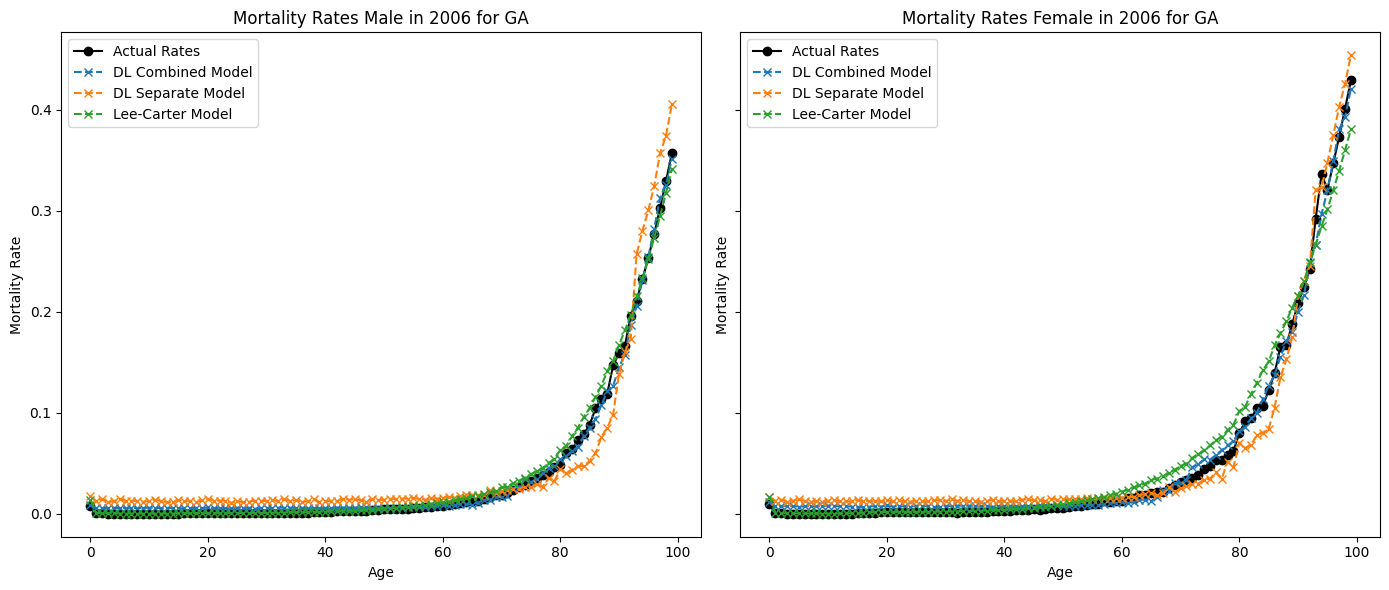

In [ ]:
figure_functions.plot_mort_predictions(geo=9, year= 2006, age_range=np.arange(0,100), genders=[0,1], data=test_data, 
                      dl_models={
                          'DL Combined': model_combined,
                          'DL Separate': model_state
                      }, model_names=['DL Combined','DL Separate', 'Lee-Carter'], lc_predictions=lc_predictions, geos_key=geos_list)

#### Plot difference from actual rates by year and age 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

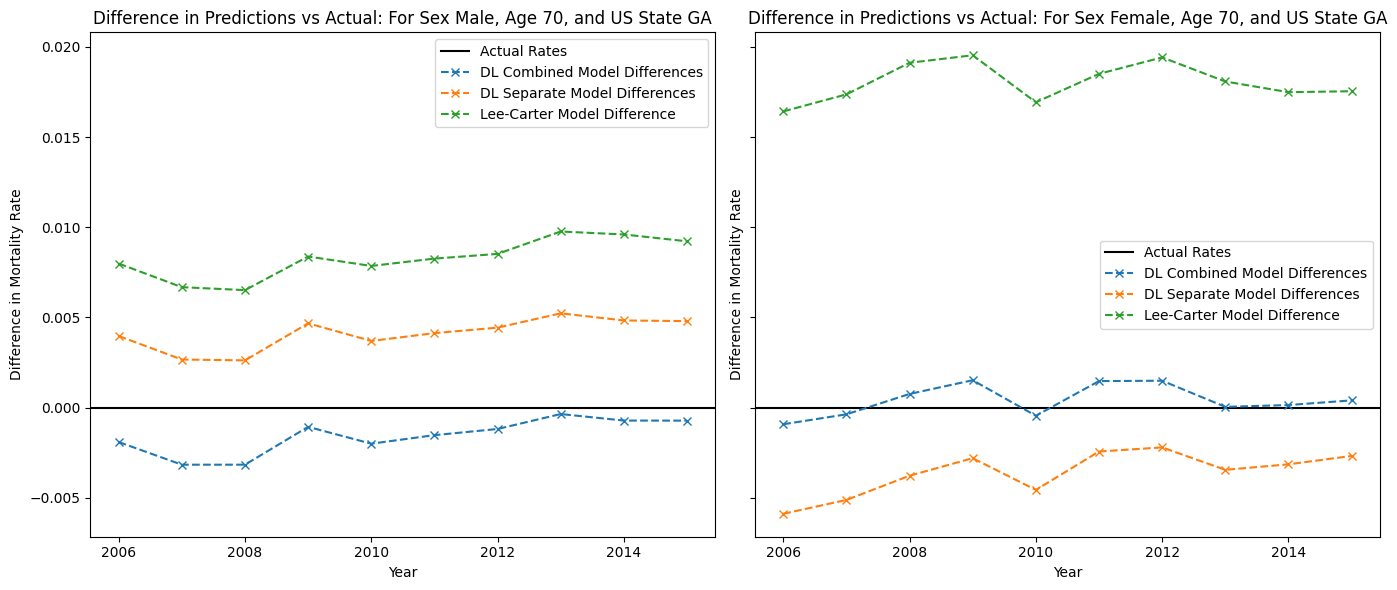

In [ ]:
figure_functions.plot_pred_diff_by_year(geo=9, year_range=np.arange(2006, 2016), age=70, genders=[0,1], data=test_data, 
                      dl_models={
                          'DL Combined': model_combined,
                          'DL Separate': model_state
                      }, model_names=['DL Combined','DL Separate', 'Lee-Carter'], lc_predictions=lc_predictions, geos_key=geos_list)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

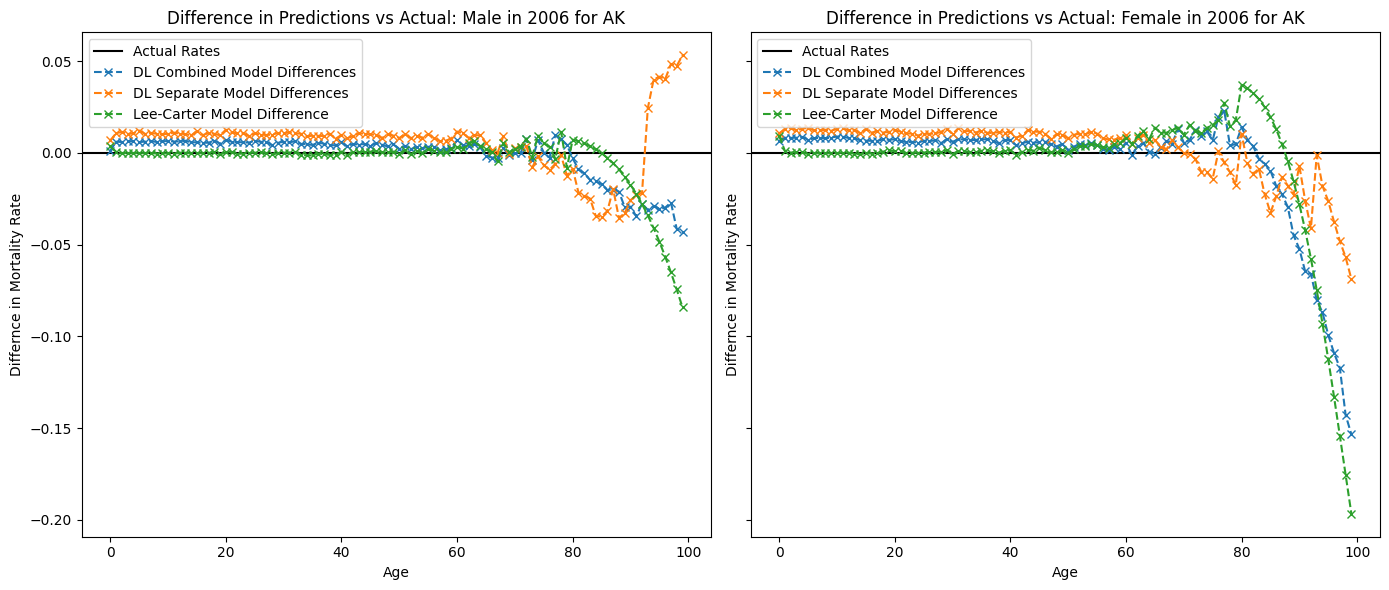

In [ ]:
figure_functions.plot_pred_diff_by_age(geo=0, year= 2006, age_range=np.arange(0,100), genders=[0,1], data=test_data, 
                      dl_models={
                          'DL Combined': model_combined,
                          'DL Separate': model_state
                      }, model_names=['DL Combined','DL Separate', 'Lee-Carter'], lc_predictions=lc_predictions, geos_key=geos_list)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

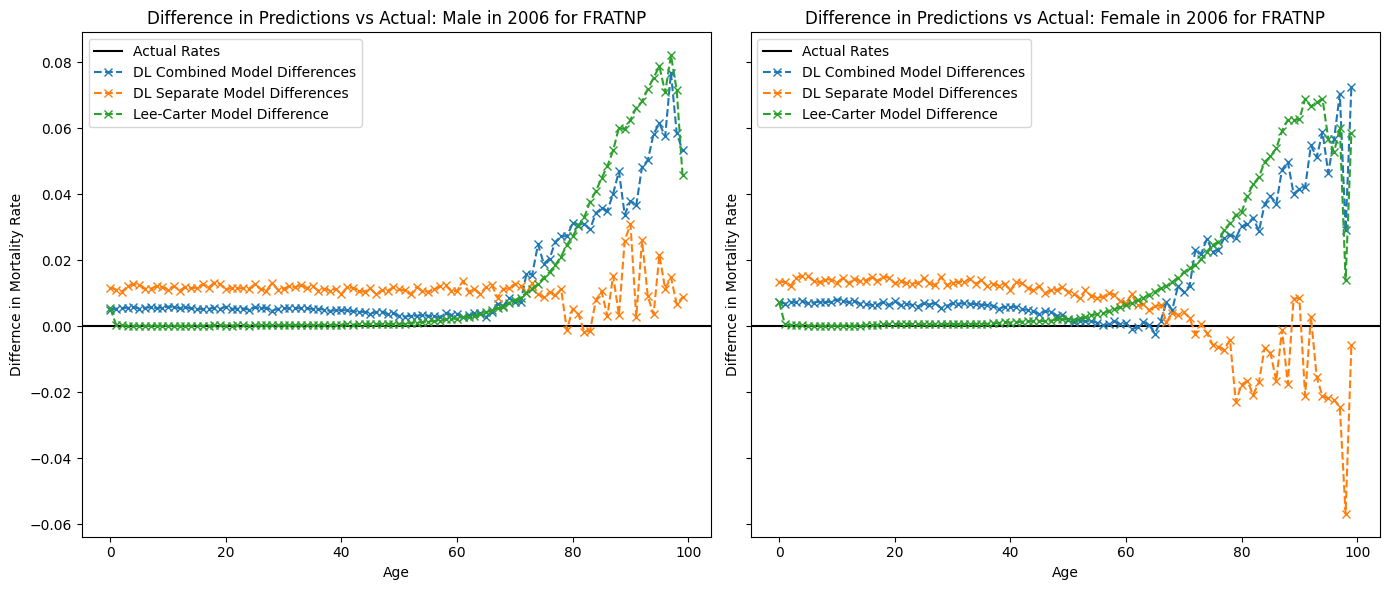

In [ ]:
plot_pred_diff_by_age(geo=62, year= 2006, age_range=np.arange(0,100), genders=[0,1], data=test_data, 
                      dl_models={
                          'DL Combined': model_combined,
                          'DL Separate': model_country
                      }, model_names=['DL Combined','DL Separate', 'Lee-Carter'], lc_predictions=lc_predictions, geos_key=geos_list)

#### Generate Subgroup MSE Barplots

Generate predictions for whole validation set, then filter sample and do MSE calculation

In [46]:
print(geos_index)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87]


In [ ]:
def calculate_mse_by_category_lc(forecasted_rates, actual_rates, feature_index):
    """
    Calculate the Mean Squared Error (MSE) between the forecasted and actual mortality rates.
    
    Args:
        forecasted_rates (numpy.ndarray): A 2D array with 5 columns representing state, gender, year, age, and forecasted mortality rate.
        actual_rates (numpy.ndarray): A 2D array with 5 columns representing state, gender, year, age, and actual mortality rate.
        
    Returns:
        float: The Mean Squared Error (MSE) between the forecasted and actual mortality rates by category.
    """

    # Ensure both arrays are sorted by geo, gender, year, and age
    forecasted_rates = forecasted_rates[np.lexsort((forecasted_rates[:, 3], forecasted_rates[:, 2], forecasted_rates[:, 1], forecasted_rates[:, 0]))]
    actual_rates = actual_rates[np.lexsort((actual_rates[:, 3], actual_rates[:, 2], actual_rates[:, 1], actual_rates[:, 0]))]

    # Find common geo/gender/year/age combinations between forecasted and actual rates
    common_keys = set(map(tuple, forecasted_rates[:, :4])) & set(map(tuple, actual_rates[:, :4]))

    # Filter both forecasted and actual rates based on common combinations
    filtered_forecasted = np.array([row for row in forecasted_rates if tuple(row[:4]) in common_keys])
    filtered_actual = np.array([row for row in actual_rates if tuple(row[:4]) in common_keys])


    
    mses_by_geo = []
    for i in geos_index:
        forecasted_values = filtered_forecasted[i, 4].astype(float)
        actual_values = filtered_actual[i, 4].astype(float)
        mse_by_geo = np.mean((forecasted_values - actual_values) ** 2)
        mses_by_geo[i] = mse_by_geo
    
    return mses_by_geo 

In [373]:
def calculate_mse_by_category(val_data, model, feature_index):
    predictions = []
    true_values = []
    feature_values = []

    for X_batch, y_batch in val_data:
        preds_batch = model(X_batch, training=False)
        predictions.append(preds_batch)
        true_values.append(y_batch)
        feature_values.append(X_batch[feature_index])

    # concatenates the list of tensors created above 
    predictions = tf.concat(predictions, axis=0).numpy()
    true_values = tf.concat(true_values, axis=0).numpy()
    feature_values = tf.concat(feature_values, axis=0).numpy()

    unique_feature_values = np.unique(feature_values)

    mse_by_category = {}

    for value in unique_feature_values:
        idx = np.where(feature_values == value)
        filtered_preds = predictions[idx]
        filtered_true_values = true_values[idx]

        mse = np.mean((filtered_preds - filtered_true_values) ** 2)

        mse_by_category[value] = mse

    return mse_by_category


In [399]:
geo_mses_combined = calculate_mse_by_category(combined_test_prepped, model_combined, feature_index=2) # 2 is geo

In [394]:
geos_mses_separate = calculate_mse_by_category(state_test_prepped, model_state, feature_index=2)

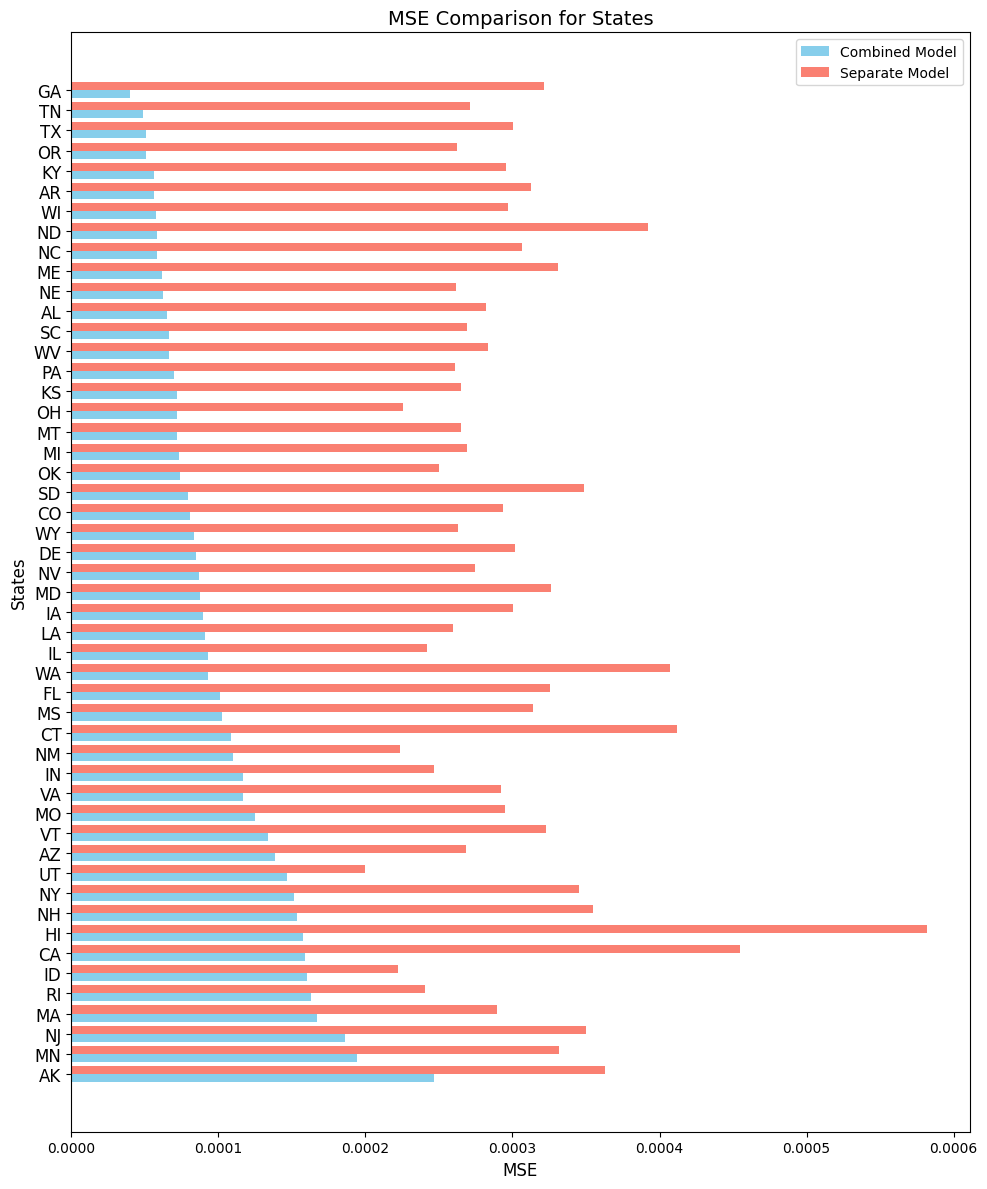

In [403]:
figure_functions.plot_mse_section(geo_mses_combined, geos_mses_separate, geos_key, "States", start=0, end=49)

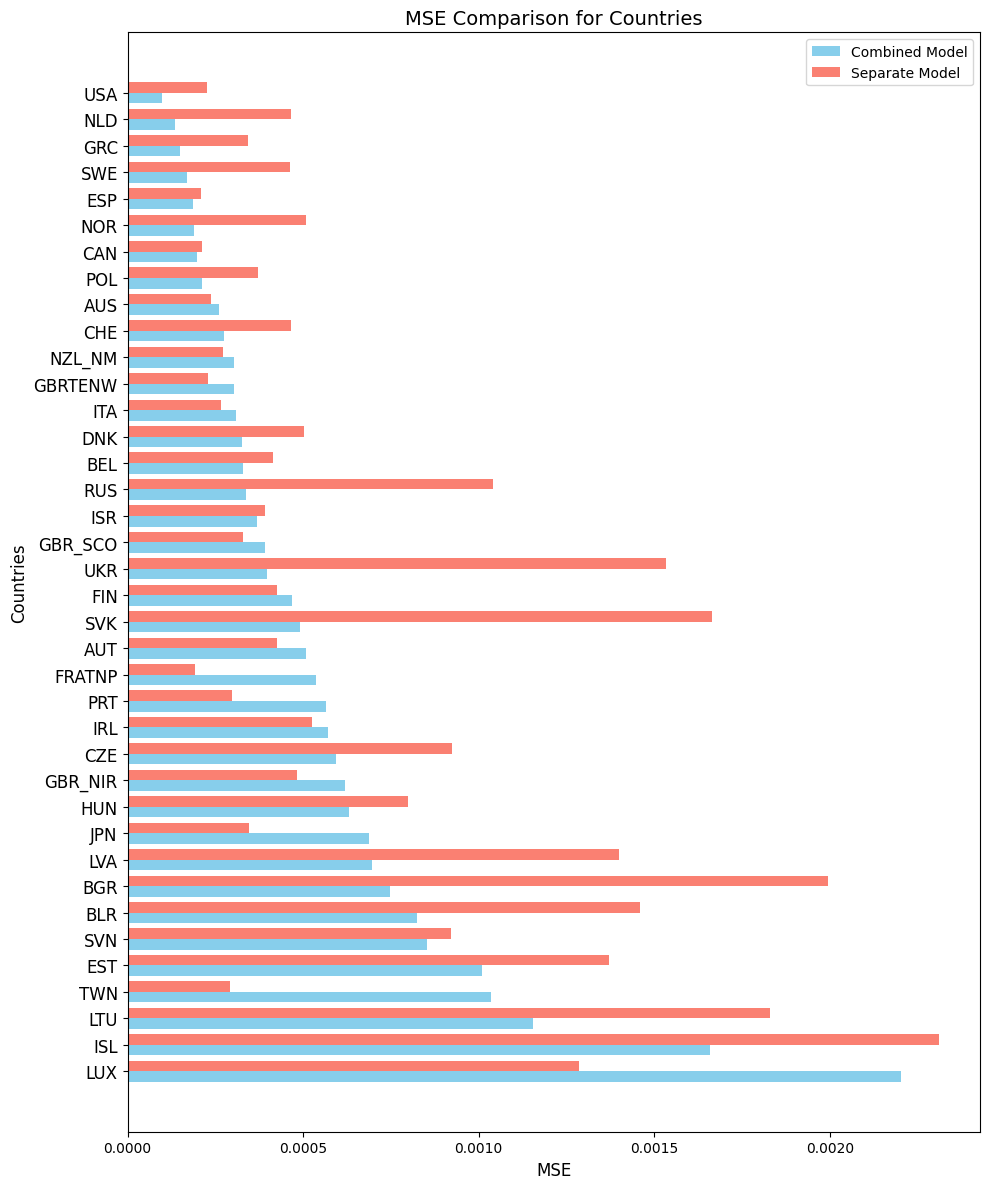

In [405]:
geos_mses_separate = calculate_mse_by_category(country_test_prepped, model_country, feature_index=2)
figure_functions.plot_mse_section(geo_mses_combined, geos_mses_separate, geos_key, "Countries", start=50, end=87)